In [98]:
import datetime as dt
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns

In [83]:
def calculate_delta(S, K, T, t, r, sigma, eps):
    d1 = (np.log(S/K) + (r + sigma ** 2 / 2) * (T - t)) / (sigma * np.sqrt(T - t) + eps)
    return norm.cdf(d1)

In [84]:
def calc_vega(S, K, T, t, r, sigma, eps):
    """Calculate option's vega"""
    d1 = (np.log(S/K) + (r + sigma ** 2 / 2) * (T - t)) / (sigma * np.sqrt(T - t) + eps)
    return S * np.sqrt(T-t) * norm.pdf(d1)

In [85]:
# Black-Scholes Call Price (in fact did not need whole equation)
def black_scholes_call(S: float, K: float, T: float, t: float, r: float, sigma: float, eps: float) -> float:
    """
    Calculate Black-Scholes call option price.
    
    Args:
        S: Current stock price
        K: Strike price
        T: Time to maturity
        t: Current time
        r: Risk-free rate
        sigma: Volatility
        eps: Small number for numerical stability
    
    Returns:
        float: Call option price
    """
    d1 = (np.log(S/K) + (r + sigma ** 2 / 2) * (T - t)) / (sigma * np.sqrt(T - t) + eps)
    d2 = d1 - sigma * np.sqrt(T-t)
    return S * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)

In [86]:
def interval_func(start, end, interval):
    result = []
    current = start
    while current <= end:
        result.append(round(current, 4))
        current += interval
    return result

In [87]:
def calc_delta(S, K, T, t, r, C_0, eps=np.finfo(float).eps, tol=0.1):

    for sigma in interval_func(0, 5, 0.001):
        c = black_scholes_call(S=S, K=K, T=T, t=t, r=r, sigma=sigma, eps=eps)
        if abs(c-C_0) <= tol:
            delta = calculate_delta(S=S, K=K, T=T, t=t, r=r, sigma=sigma, eps=eps)
            # print(f"Delta = {delta}, sigma = {sigma}, Price: {S}, S-C={S-C_0} \ncall price from BS = {round(c, 5)}, Call price from data = {C_0}")
            return delta
    # print(f"Delta = 1, sigma = 0, call from BS if sigma = 0: {black_scholes_call(S=S, K=K, T=T, t=t, r=r, sigma=0, eps=eps)} Call price from data = {C_0}")
    return 1

In [88]:
def calc_delta_recursive(S, K, T, t, r, C_0, eps=np.finfo(float).eps, tol=0.1, max_tol=2.0):
    """
    Recursively calculate delta with increasing tolerance until solution is found
    or max_tolerance is reached
    """
    if tol > max_tol:
        # print(f"Warning: No solution found within tolerance {max_tol}")
        print(f"Delta = 1, sigma = 0, call from BS if sigma = 0: {black_scholes_call(S=S, K=K, T=T, t=t, r=r, sigma=0, eps=eps)} Call price from data = {C_0}")
        return 1, 0 

    for sigma in np.arange(0, 5, 0.001):
        c = black_scholes_call(S=S, K=K, T=T, t=t, r=r, sigma=sigma, eps=eps)
        if abs(c - C_0) <= tol:
            delta = calculate_delta(S=S, K=K, T=T, t=t, r=r, sigma=sigma, eps=eps)
            return delta, sigma

    # print(f'Increasing tolerance from {tol} to {tol + 0.2}')
    return calc_delta_recursive(S, K, T, t, r, C_0, eps, tol + 0.2, max_tol)

# Equation (1): Alpha Calculation

$$
\alpha = \frac{\partial C^{BS}}{\partial S} - \frac{\frac{\partial C^{BS}}{\partial \sigma}}{\frac{\partial C^{Rep}}{\partial \sigma}} \cdot \frac{\partial C^{Rep}}{\partial S}
$$

Where:
- $\alpha$ is the hedge ratio for the underlying asset

- $\frac{\partial C^{BS}}{\partial S}$ is the delta of the original Black-Scholes option

- $\frac{\partial C^{BS}}{\partial \sigma}$ is the vega of the original Black-Scholes option

- $\frac{\partial C^{Rep}}{\partial \sigma}$ is the vega of the replicating option

- $\frac{\partial C^{Rep}}{\partial S}$ is the delta of the replicating option


In [89]:
def calc_alpha(S, K, T, t, r, sigma, eps, T2):
    """Calculate alpha according to equation (1)"""
    # Calculate delta of original option
    delta_BS = calc_delta_recursive(S, K, T, t, r, sigma, eps)
    
    # Calculate vegas
    vega_BS = calc_vega(S, K, T, t, r, sigma, eps)
    vega_rep = calc_vega(S, K, T2, t, r, sigma, eps)
    
    # Calculate delta of replicating option
    delta_rep = calculate_delta(S, K, T2, t, r, sigma, eps)
    
    # Equation (1): α = ∂C^BS/∂S - (∂C^BS/∂σ)/(∂C^Rep/∂σ) * ∂C^Rep/∂S
    alpha = delta_BS - (vega_BS/vega_rep) * delta_rep
    
    return alpha

In [90]:
def hedging_delta_vega(interval, strike, df, delta, vega_BS, C_0, S_0, maturity_date, T, T2, r):
    """
    Delta-vega hedging implementation with data collection for analysis.

    Args:
        interval: Rehedging interval.
        strike: Strike price identifier (e.g., 'C180').
        df: DataFrame containing option prices.
        delta: Initial delta.
        vega_BS: Initial vega of the original option.
        C_0: Initial option price.
        S_0: Initial stock price.
        maturity_date: Maturity date for the original option.
        T: Initial time to maturity for the original option.
        T2: Initial time to maturity for the replicating option.
        r: Risk-free rate.
    """
   
    df['Date'] = pd.to_datetime(df['Date'])
    maturity_date = pd.to_datetime(maturity_date)

    option_period = []
    alphas = []
    etas = []
    vegas_bs = []
    vegas_rep = []
    ops = []  
    res = []  

    A_boss = 0
    interval_count = 1
    c_0 = C_0
    s_0 = S_0
    n = 0

    K = float(strike.split('C')[1])

    print(f"Delta-Vega Hedging for Strike: {strike}")
    print(f"Initial Delta (Original): {delta:.6f}, Vega (Original): {vega_BS:.6f}\n")

    for _, row in df.iterrows():
        c_1 = float(row[strike])
        s_1 = float(row['Underlying'])

        current_date = pd.to_datetime(row['Date'])

        # Time to maturity calculations
        t = (maturity_date - current_date).days / 365
        t2 = T2 - ((current_date - (maturity_date - dt.timedelta(days=45))).days / 365)

        delta_BS = calculate_delta(S=s_1, K=K, T=t, t=0, r=r, sigma=0.2, eps=1e-6)
        vega_BS = calc_vega(S=s_1, K=K, T=t, t=0, r=r, sigma=0.2, eps=1e-6)

        delta_rep = calculate_delta(S=s_1, K=K, T=t2, t=0, r=r, sigma=0.2, eps=1e-6)
        vega_rep = calc_vega(S=s_1, K=K, T=t2, t=0, r=r, sigma=0.2, eps=1e-6)

        alpha = delta_BS - (vega_BS / vega_rep) * delta_rep
        eta = vega_BS / vega_rep

        OP = c_1 - c_0
        RE = -alpha * (s_1 - s_0) - eta * (s_1 - s_0)
        A = OP + RE
        A_boss += A ** 2
        n += 1

        option_period.append((current_date - df['Date'].iloc[0]).days)
        alphas.append(alpha)
        etas.append(eta)
        vegas_bs.append(vega_BS)
        vegas_rep.append(vega_rep)
        ops.append(OP)
        res.append(RE)

        if interval_count % interval == 0:
            delta = delta_BS
            vega_BS = calc_vega(S=s_1, K=K, T=t, t=0, r=r, sigma=0.2, eps=1e-6)

        c_0 = c_1
        s_0 = s_1
        interval_count += 1

    mse = A_boss / (n - 1)
    print(f"Final MSE for Strike {strike}: {mse:.6f}\n")

    return mse, option_period, alphas, etas, vegas_bs, vegas_rep, ops, res


In [91]:
def run_hedging_analysis(filename, interval=2, risk_free_rate=0.05):
    df = pd.read_feather(filename)
    df['Date'] = pd.to_datetime(df['Date']).dt.date

    df['Underlying'] = pd.to_numeric(df['Underlying'], errors='coerce')
    for col in [col for col in df.columns if col.startswith('C')]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    date_str = filename.split('apple')[1].split('.')[0]
    maturity_date = dt.datetime.strptime(date_str, '%d%m%Y').date()

    t = 0
    r = risk_free_rate / 100
    eps = np.finfo(float).eps

    # Time to maturity
    T = 45 / 365  # Original option maturity: 45 days
    T2 = 70 / 365  # Replicating option maturity: 70 days

    start_date = maturity_date - dt.timedelta(days=45)
    analysis_df = df[df['Date'] >= start_date]
    analysis_df = analysis_df[analysis_df['Date'] <= maturity_date]

    if not analysis_df.empty:
        hedging_start_value = analysis_df.loc[analysis_df['Date'] == start_date, 'Underlying']
        if not hedging_start_value.empty:
            print(f"Hedging Start Date: {start_date}, Underlying Value: {hedging_start_value.values[0]}")
    else:
        print(f"No data available for the analysis window {start_date} to {maturity_date}")

    strikes = [col.replace('C', '') for col in df.columns if col.startswith('C') and not df[col].isna().any()]
    print()
    print(f"Strikes: {strikes}")

    results = []
    for k in strikes:
        print(f"-------------- Strike: {k} ----------------")
        strike = f'C{k}'

        C_0 = float(analysis_df[strike].iloc[0])
        S_0 = float(analysis_df['Underlying'].iloc[0])

        delta, _ = calc_delta_recursive(S=S_0, K=float(k), T=T, t=t, r=r, C_0=C_0)
        vega_BS = calc_vega(S=S_0, K=float(k), T=T, t=t, r=r, sigma=0.2, eps=1e-6)

        delta_vega_error, option_period, alphas, etas, vegas_bs, vegas_rep, ops, res = hedging_delta_vega(
            interval, strike, analysis_df, delta, vega_BS, C_0, S_0, maturity_date, T, T2, r
        )

        results.append({
            "Strike": k,
            "Delta__Vega_MSE": delta_vega_error,
            "Option_Period": option_period,
            "Deltas": alphas,
            "Etas": etas,
            "Vegas_BS": vegas_bs,
            "Vegas_Rep": vegas_rep,
            "OP": ops,
            "RE": res,
            "Underlying": S_0
        })

    return pd.DataFrame(results)


In [92]:
dates = ['19012024', '16022024', '15032024','19042024','17052024', '21062024', '19072024', '16082024', '20092024']  # '25102024' Not enough data for this dataset
for date in dates:
    filename = f'data/apple{date}.feather'
    df = pd.read_feather(filename)
    maturity_date = dt.datetime.strptime(date, '%d%m%Y').date()
    hedging_start_date = maturity_date - dt.timedelta(days=45)
    hedging_start_date_replicating = maturity_date - dt.timedelta(days=70)
    hedging_start_value = df.loc[df['Date'].dt.date == hedging_start_date, 'Underlying']
    hedging_start_value_rep = df.loc[df['Date'].dt.date == hedging_start_date_replicating, 'Underlying']
    print()
    print(f"Hedging Start: {hedging_start_date} | Maturity: {maturity_date} | Hedging Start Replicating: {hedging_start_date_replicating}")
    print(f"Underlying Value: {hedging_start_value.values[0]}  | Underlying Value REp: {hedging_start_value_rep.values[0]}")
    


Hedging Start: 2023-12-05 | Maturity: 2024-01-19 | Hedging Start Replicating: 2023-11-10
Underlying Value: 193.42  | Underlying Value REp: 186.4

Hedging Start: 2024-01-02 | Maturity: 2024-02-16 | Hedging Start Replicating: 2023-12-08
Underlying Value: 185.64  | Underlying Value REp: 195.71

Hedging Start: 2024-01-30 | Maturity: 2024-03-15 | Hedging Start Replicating: 2024-01-05
Underlying Value: 188.04  | Underlying Value REp: 181.18

Hedging Start: 2024-03-05 | Maturity: 2024-04-19 | Hedging Start Replicating: 2024-02-09
Underlying Value: 170.12  | Underlying Value REp: 188.85

Hedging Start: 2024-04-02 | Maturity: 2024-05-17 | Hedging Start Replicating: 2024-03-08
Underlying Value: 168.84  | Underlying Value REp: 170.73

Hedging Start: 2024-05-07 | Maturity: 2024-06-21 | Hedging Start Replicating: 2024-04-12
Underlying Value: 182.4  | Underlying Value REp: 176.55

Hedging Start: 2024-06-04 | Maturity: 2024-07-19 | Hedging Start Replicating: 2024-05-10
Underlying Value: 194.35  | Un

In [93]:
# Process multiple datasets
dates = ['19012024', '16022024', '15032024','19042024','17052024', '21062024', '19072024', '16082024', '20092024']  # '25102024' Not enough data for this dataset
all_results = []
# https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve

risk_free_rates = {  # Risk free rates for each maturity, risk free rate is chosen 3 month Daily Treasury Par Yield Curve Rates for the hedging start date
    '19012024': 5.53,
    '16022024': 5.44,
    '15032024': 5.47,
    '19042024': 5.44,
    '17052024': 5.46,
    '21062024': 5.45,
    '19072024': 5.47,
    '16082024': 5.52,
    '20092024': 5.43
}

for date in dates:
    filename = f'data/apple{date}.feather'
    r = risk_free_rates.get(date, 0.05)
    results = run_hedging_analysis(filename, risk_free_rate=r)
    results["Maturity"] = date
    all_results.append(results)

final_results = pd.concat(all_results)

final_results.to_csv("hedging_results.csv", index=False)

Hedging Start Date: 2023-12-05, Underlying Value: 193.42

Strikes: ['200', '210', '220']
-------------- Strike: 200 ----------------
Delta-Vega Hedging for Strike: C200
Initial Delta (Original): 0.324335, Vega (Original): 25.535774

Final MSE for Strike C200: 0.358652

-------------- Strike: 210 ----------------
Delta-Vega Hedging for Strike: C210
Initial Delta (Original): 0.077013, Vega (Original): 15.793750

Final MSE for Strike C210: 0.375971

-------------- Strike: 220 ----------------
Delta-Vega Hedging for Strike: C220
Initial Delta (Original): 0.000000, Vega (Original): 6.372394

Final MSE for Strike C220: 0.177490

Hedging Start Date: 2024-01-02, Underlying Value: 185.64

Strikes: ['200', '210']
-------------- Strike: 200 ----------------
Delta-Vega Hedging for Strike: C200
Initial Delta (Original): 0.169533, Vega (Original): 16.868784

Final MSE for Strike C200: 0.666602

-------------- Strike: 210 ----------------
Delta-Vega Hedging for Strike: C210
Initial Delta (Original): 

In [94]:
import matplotlib.pyplot as plt

def categorize_strikes(final_results, threshold=5):
    """
    Categorize strikes as ITM, ATM, or OTM based on underlying price and threshold.
    For call options:
    - ITM: Strike < Underlying (S > K)
    - OTM: Strike > Underlying (S < K)
    - ATM: Strike ≈ Underlying (within threshold)
    """
    def classify_strike(row):
        underlying_price = float(row['Underlying'])
        strike_price = float(row['Strike'])
        
        lower_bound = underlying_price - threshold
        upper_bound = underlying_price + threshold
        
        if strike_price > upper_bound:
            print(f"Strike {strike_price} is OTM, Underlying {underlying_price}")
            return 'OTM'
        elif strike_price < lower_bound:
            print(f"Strike {strike_price} is ITM, Underlying {underlying_price}")
            return 'ITM'
        else:
            print(f"Strike {strike_price} is ATM, Underlying {underlying_price}")
            return 'ATM'

    final_results['Strike_Category'] = final_results.apply(classify_strike, axis=1)

    print("\nSample categorizations:")
    print(final_results[['Strike', 'Underlying', 'Strike_Category']].head(10))

    print("\nCategory distribution:")
    print(final_results['Strike_Category'].value_counts())

categorize_strikes(final_results)

Strike 200.0 is OTM, Underlying 193.42
Strike 210.0 is OTM, Underlying 193.42
Strike 220.0 is OTM, Underlying 193.42
Strike 200.0 is OTM, Underlying 185.64
Strike 210.0 is OTM, Underlying 185.64
Strike 200.0 is OTM, Underlying 188.04
Strike 210.0 is OTM, Underlying 188.04
Strike 200.0 is OTM, Underlying 170.12
Strike 210.0 is OTM, Underlying 170.12
Strike 200.0 is OTM, Underlying 168.84
Strike 210.0 is OTM, Underlying 168.84
Strike 200.0 is OTM, Underlying 182.4
Strike 210.0 is OTM, Underlying 182.4
Strike 220.0 is OTM, Underlying 182.4
Strike 230.0 is OTM, Underlying 182.4
Strike 240.0 is OTM, Underlying 182.4
Strike 200.0 is OTM, Underlying 194.35
Strike 210.0 is OTM, Underlying 194.35
Strike 220.0 is OTM, Underlying 194.35
Strike 230.0 is OTM, Underlying 194.35
Strike 200.0 is ITM, Underlying 220.27
Strike 210.0 is ITM, Underlying 220.27
Strike 220.0 is ATM, Underlying 220.27
Strike 230.0 is OTM, Underlying 220.27
Strike 240.0 is OTM, Underlying 220.27
Strike 200.0 is ITM, Underlyin

In [96]:
results_df = final_results

Strike_Category
ATM    0.704981
ITM    0.424609
OTM    0.804923
Name: Delta__Vega_MSE, dtype: float64


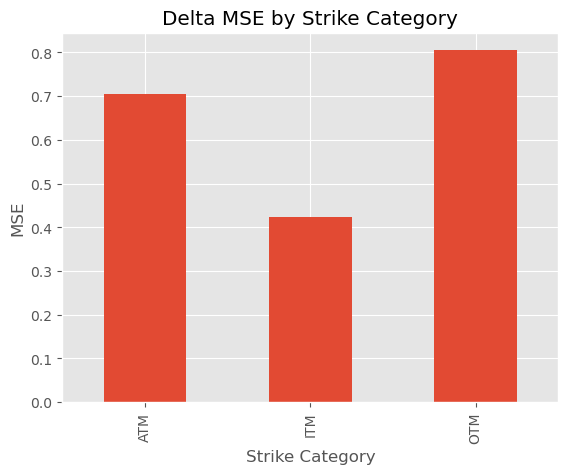

In [103]:
results_df['Maturity'] = pd.to_datetime(results_df['Maturity'], format='%d%m%Y')
plt.style.use('ggplot')
grouped = final_results.groupby('Strike_Category')['Delta__Vega_MSE'].mean()
print(grouped)
grouped.plot(kind='bar', title='Delta MSE by Strike Category', ylabel='MSE', xlabel='Strike Category')
plt.show()

<Figure size 1000x600 with 0 Axes>

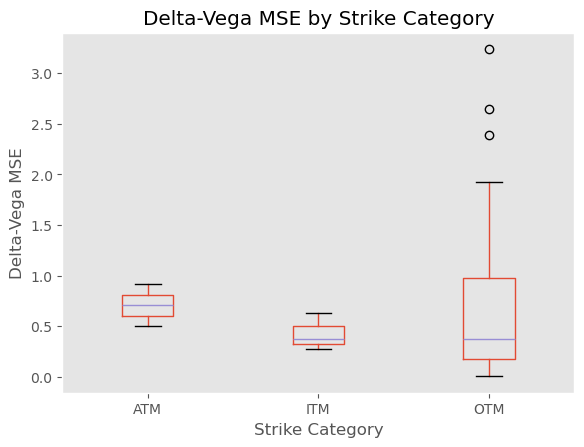

In [130]:
plt.figure(figsize=(10, 6))
final_results.boxplot(column='Delta__Vega_MSE', by='Strike_Category', grid=False)
plt.title('Delta-Vega MSE by Strike Category')
plt.suptitle('')
plt.xlabel('Strike Category')
plt.ylabel('Delta-Vega MSE')
plt.show()


In [122]:
strike_to_plot = final_results[final_results['Strike_Category'] == 'ATM']

for idx, row in strike_to_plot.iterrows():
    option_period = eval(row['Option_Period']) if isinstance(row['Option_Period'], str) else row['Option_Period']
    deltas = eval(row['Deltas']) if isinstance(row['Deltas'], str) else row['Deltas']
    
    plt.plot(option_period, deltas, label=f"Strike {row['Strike']}")

plt.title('Delta Evolution Over Time with ATM Strike')
plt.xlabel('Elapsed Days')
plt.ylabel('Delta')
plt.legend()
plt.show()


TypeError: eval() arg 1 must be a string, bytes or code object

<Figure size 1200x800 with 0 Axes>

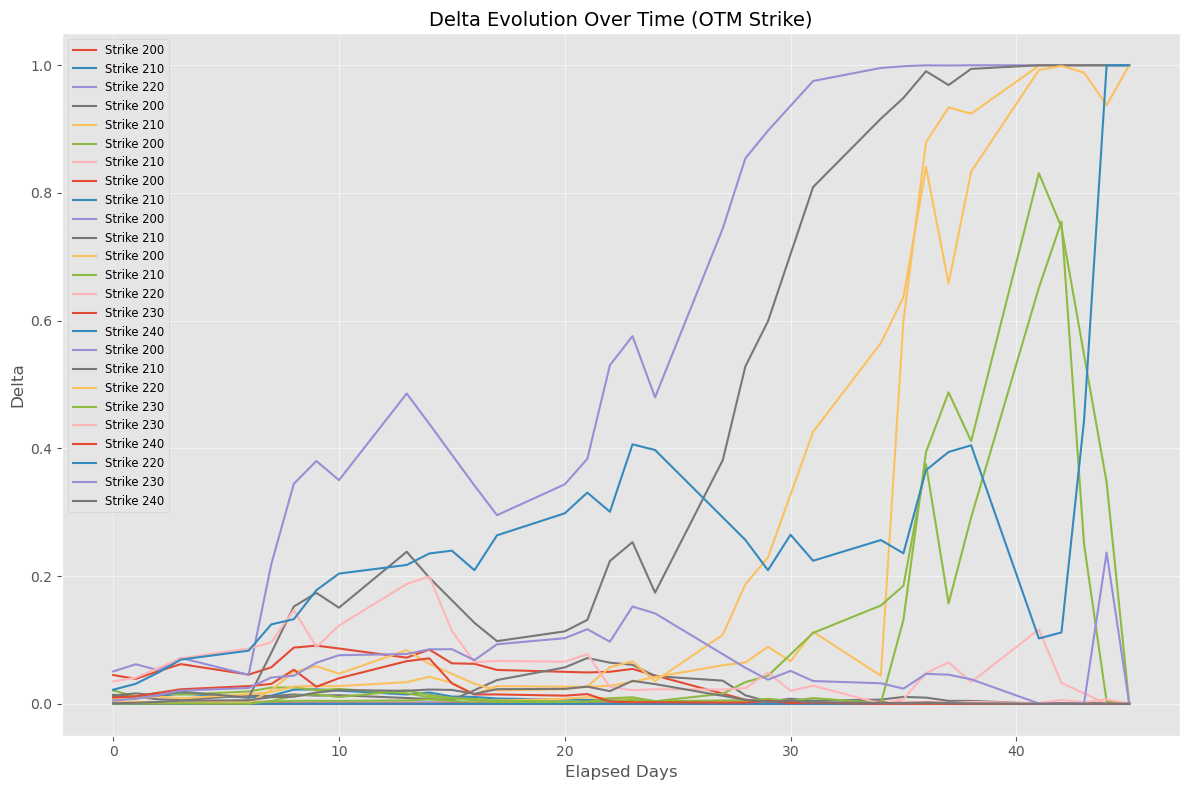

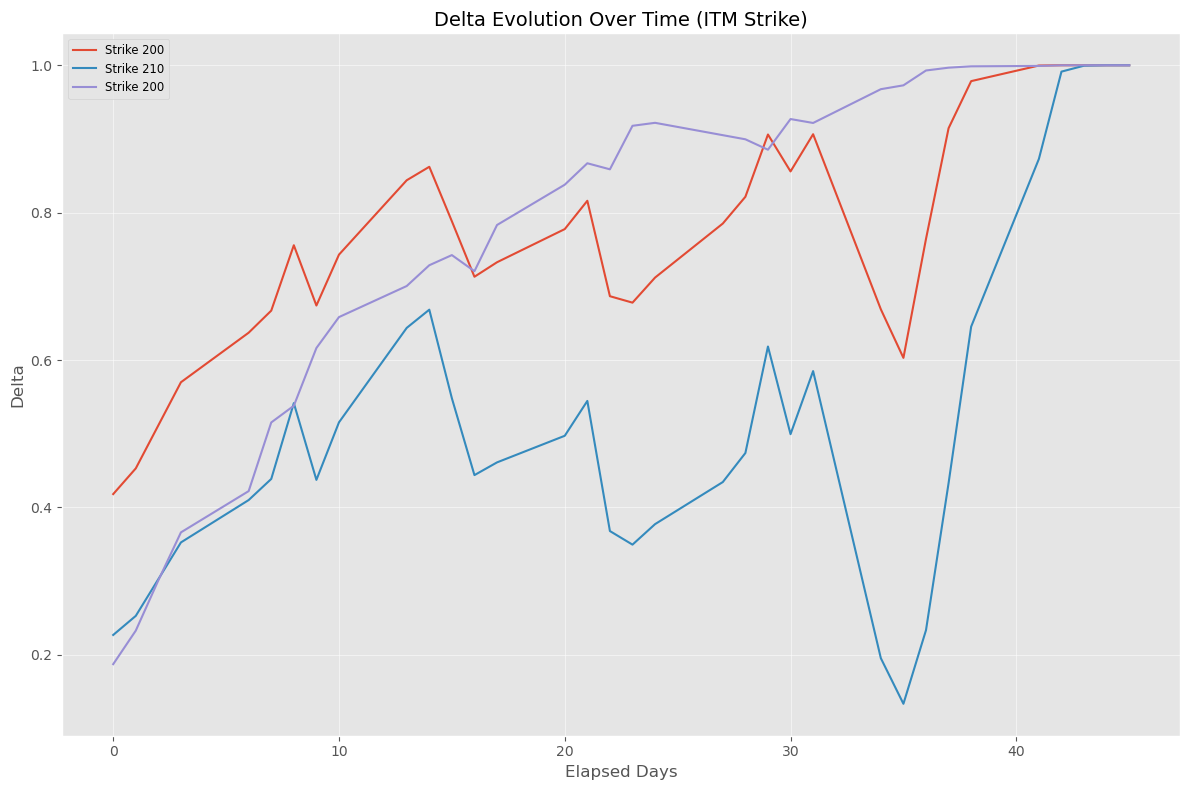

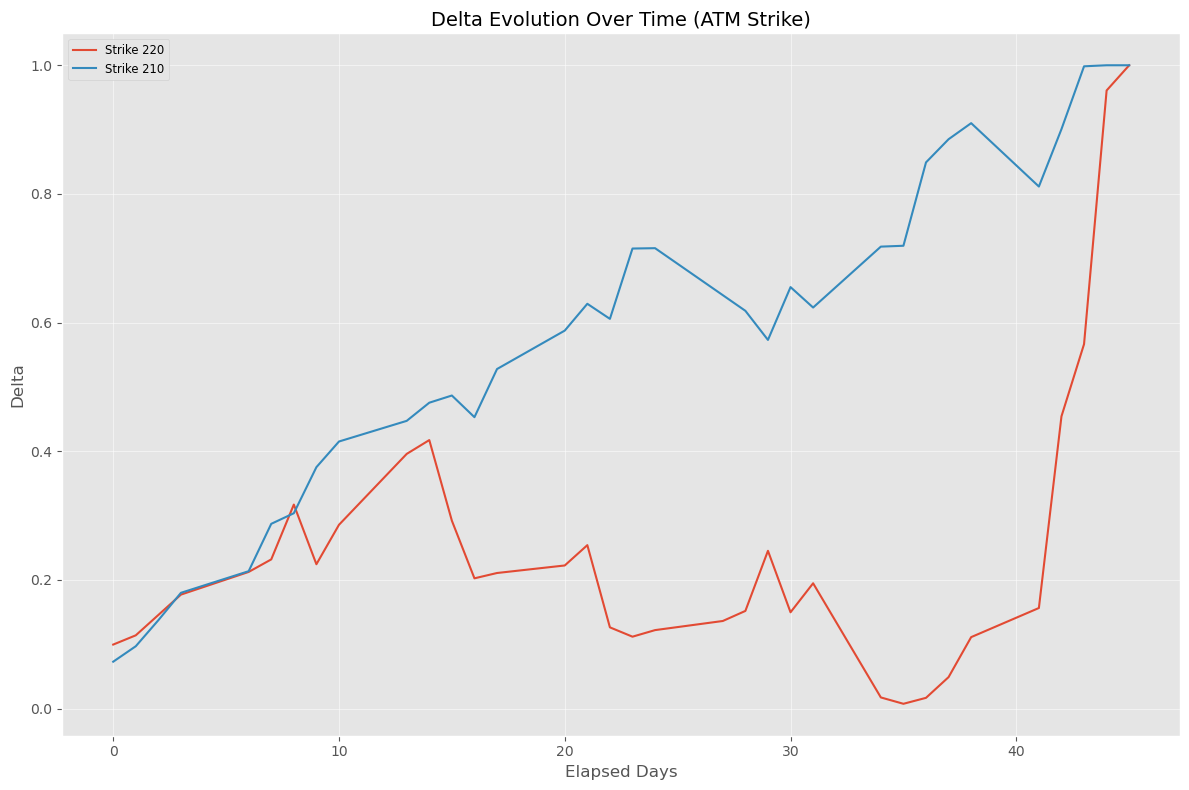

In [123]:
# Loop through each strike category and plot Delta Evolution for each category
categories = results_df['Strike_Category'].unique()

for category in categories:
    strike_to_plot = results_df[results_df['Strike_Category'] == category]
    
    plt.figure(figsize=(12, 8))
    for idx, row in strike_to_plot.iterrows():
        option_period = eval(row['Option_Period']) if isinstance(row['Option_Period'], str) else row['Option_Period']
        deltas = eval(row['Deltas']) if isinstance(row['Deltas'], str) else row['Deltas']
        
        plt.plot(option_period, deltas, label=f"Strike {row['Strike']}")

    plt.title(f'Delta Evolution Over Time ({category} Strike)', fontsize=14)
    plt.xlabel('Elapsed Days', fontsize=12)
    plt.ylabel('Delta', fontsize=12)
    plt.legend(fontsize='small', loc='best')
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

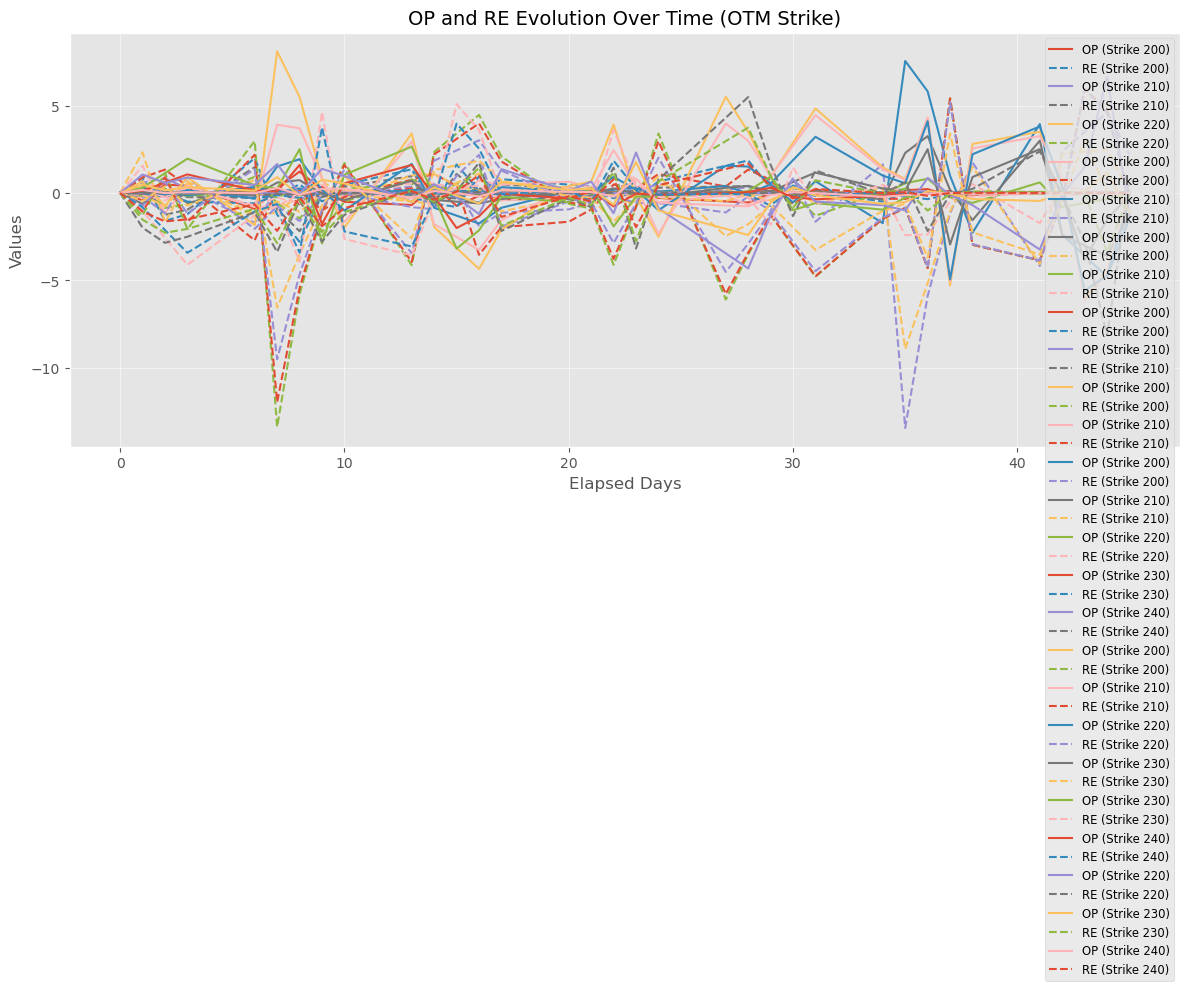

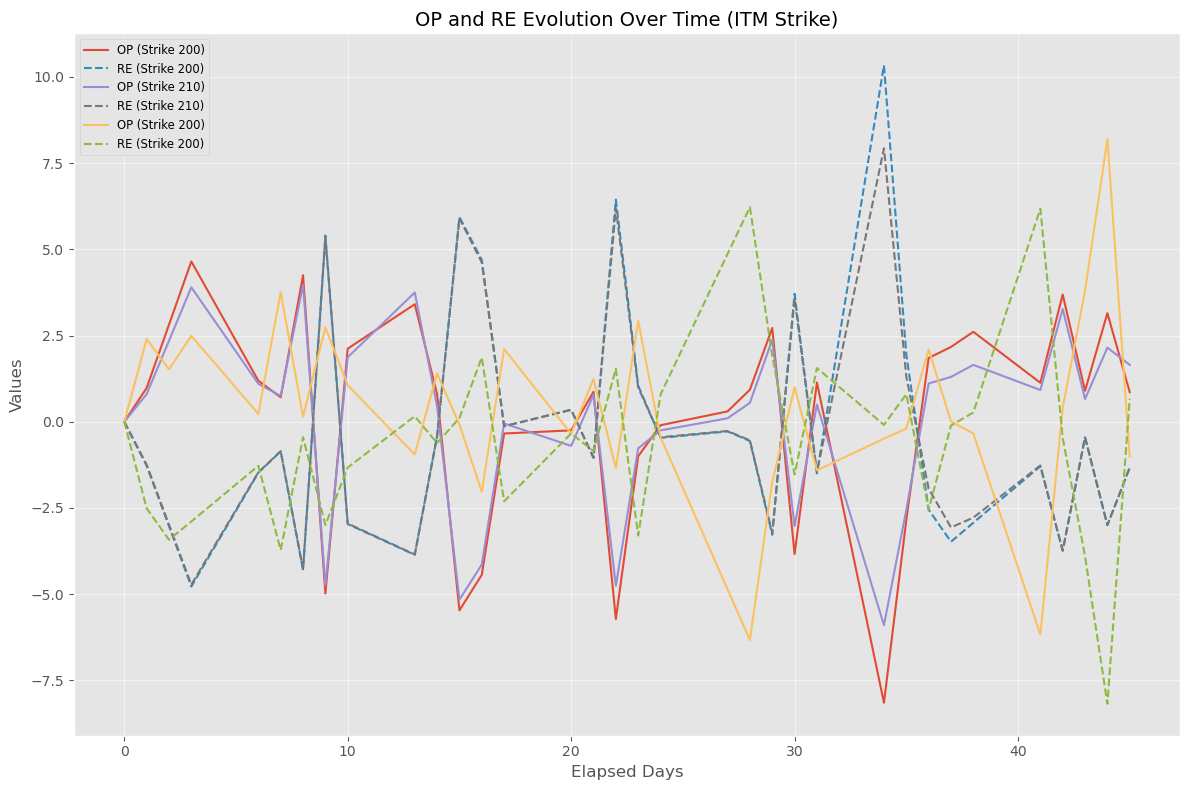

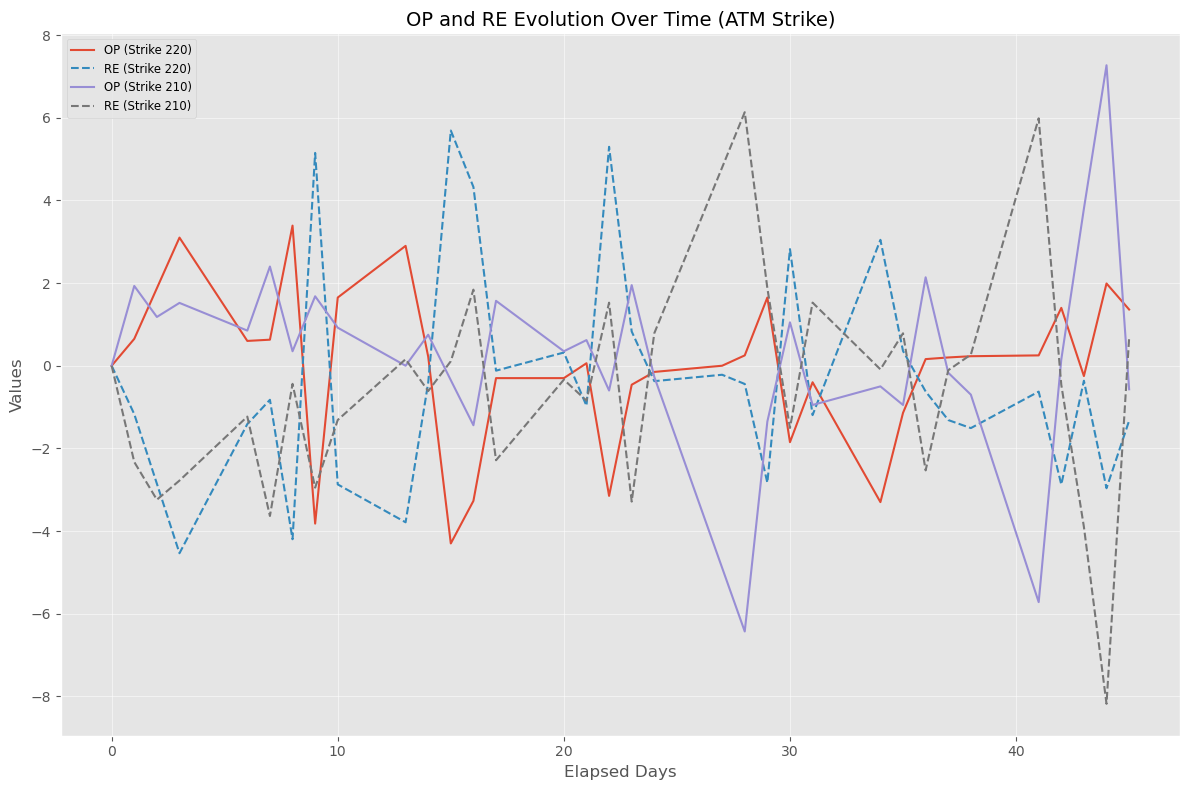

In [127]:
# Plot OP (Option Price Change) and RE (Replicating Portfolio Adjustment) values for each strike category
for category in categories:
    strike_to_plot = results_df[results_df['Strike_Category'] == category]
    
    plt.figure(figsize=(12, 8))
    for idx, row in strike_to_plot.iterrows():
        option_period = eval(row['Option_Period']) if isinstance(row['Option_Period'], str) else row['Option_Period']
        op_values = eval(row['OP']) if isinstance(row['OP'], str) else row['OP']
        re_values = eval(row['RE']) if isinstance(row['RE'], str) else row['RE']
        
        # Plot OP
        plt.plot(option_period, op_values, label=f"OP (Strike {row['Strike']})", linestyle='-')
        
        # Plot RE
        plt.plot(option_period, re_values, label=f"RE (Strike {row['Strike']})", linestyle='--')

    plt.title(f'OP and RE Evolution Over Time ({category} Strike)', fontsize=14)
    plt.xlabel('Elapsed Days', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.legend(fontsize='small', loc='best')
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()


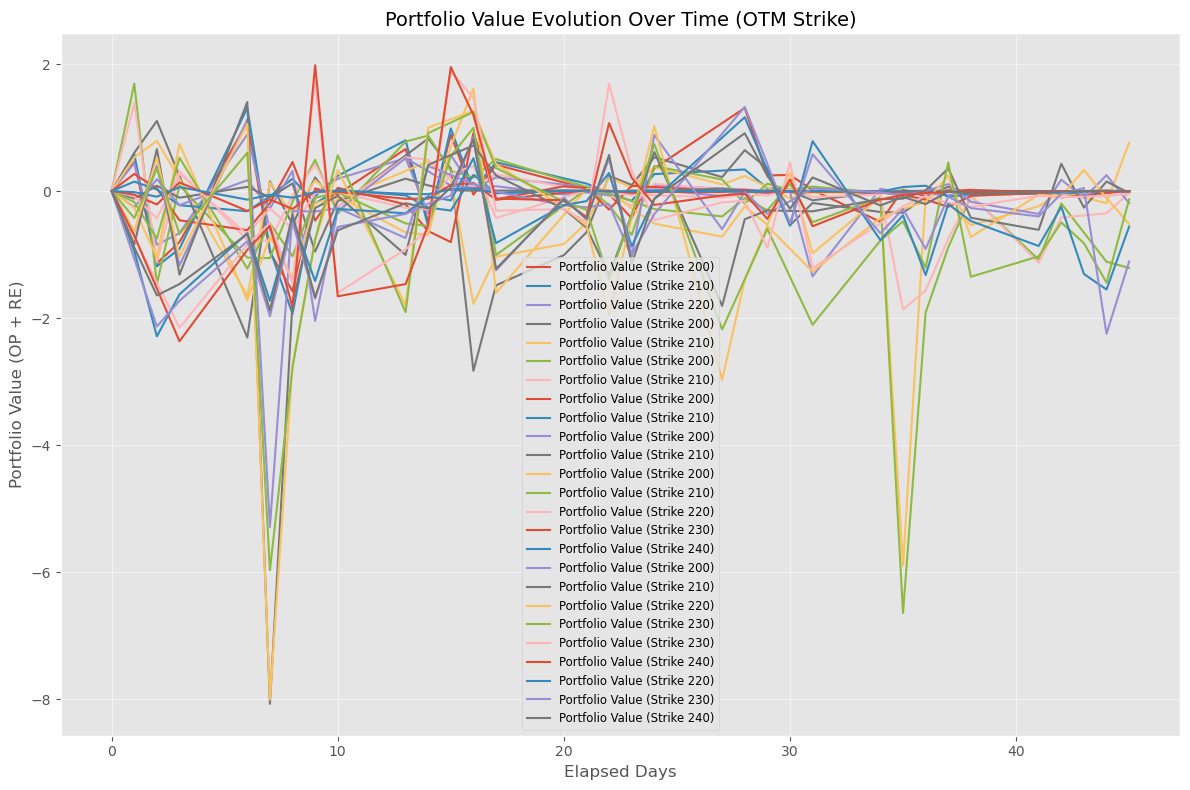

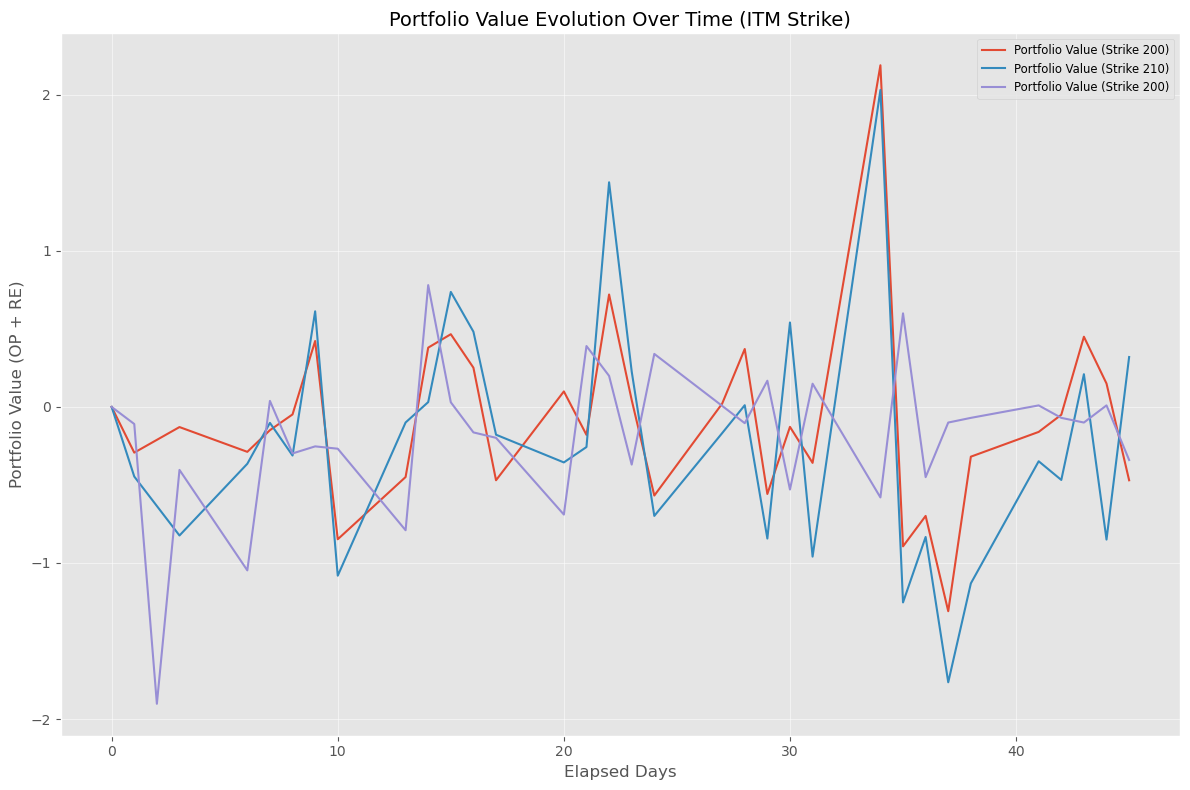

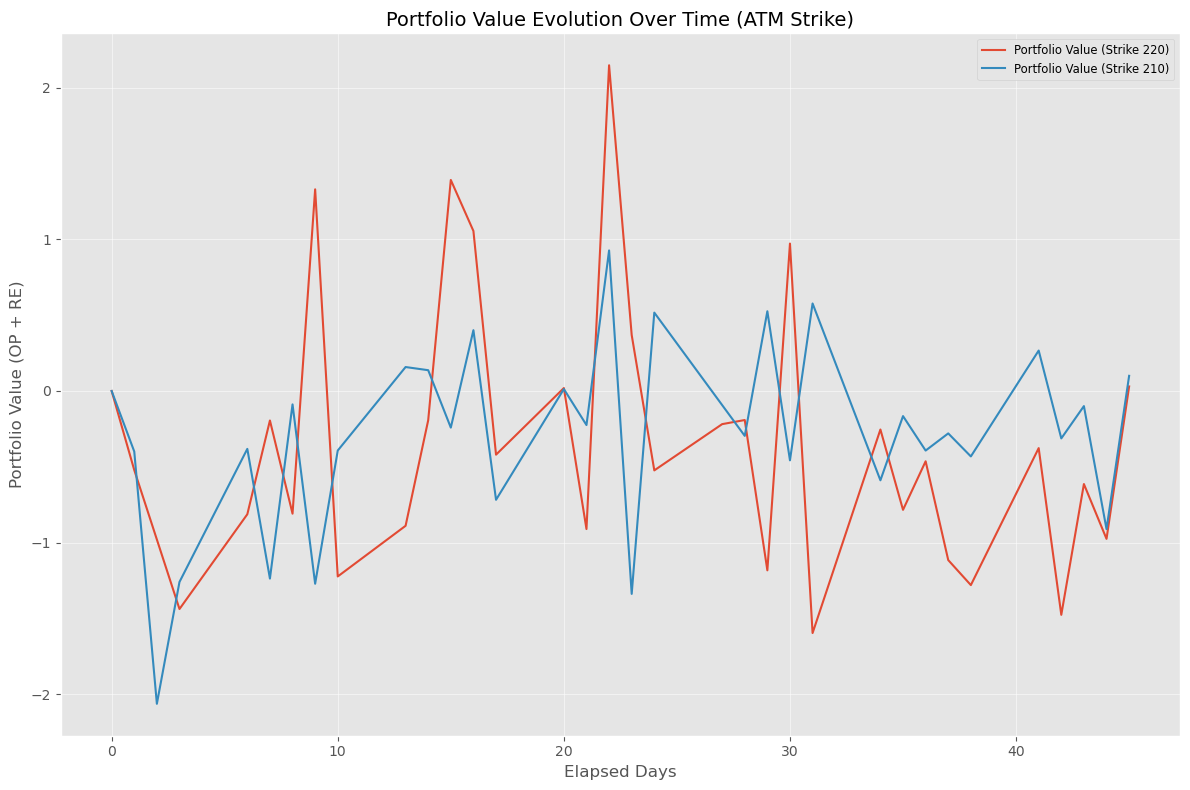

In [126]:
# Extract unique categories for plotting
categories = results_df['Strike_Category'].unique()

# Plot OP + RE values for each strike category to check portfolio stability over time
for category in categories:
    strike_to_plot = results_df[results_df['Strike_Category'] == category]
    
    plt.figure(figsize=(12, 8))
    for idx, row in strike_to_plot.iterrows():
        option_period = eval(row['Option_Period']) if isinstance(row['Option_Period'], str) else row['Option_Period']
        op_values = eval(row['OP']) if isinstance(row['OP'], str) else row['OP']
        re_values = eval(row['RE']) if isinstance(row['RE'], str) else row['RE']
        
        # Calculate OP + RE for each time step
        portfolio_values = [op + re for op, re in zip(op_values, re_values)]
        
        # Plot OP + RE (Portfolio values)
        plt.plot(option_period, portfolio_values, label=f"Portfolio Value (Strike {row['Strike']})", linestyle='-')

    plt.title(f'Portfolio Value Evolution Over Time ({category} Strike)', fontsize=14)
    plt.xlabel('Elapsed Days', fontsize=12)
    plt.ylabel('Portfolio Value (OP + RE)', fontsize=12)
    plt.legend(fontsize='small', loc='best')
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

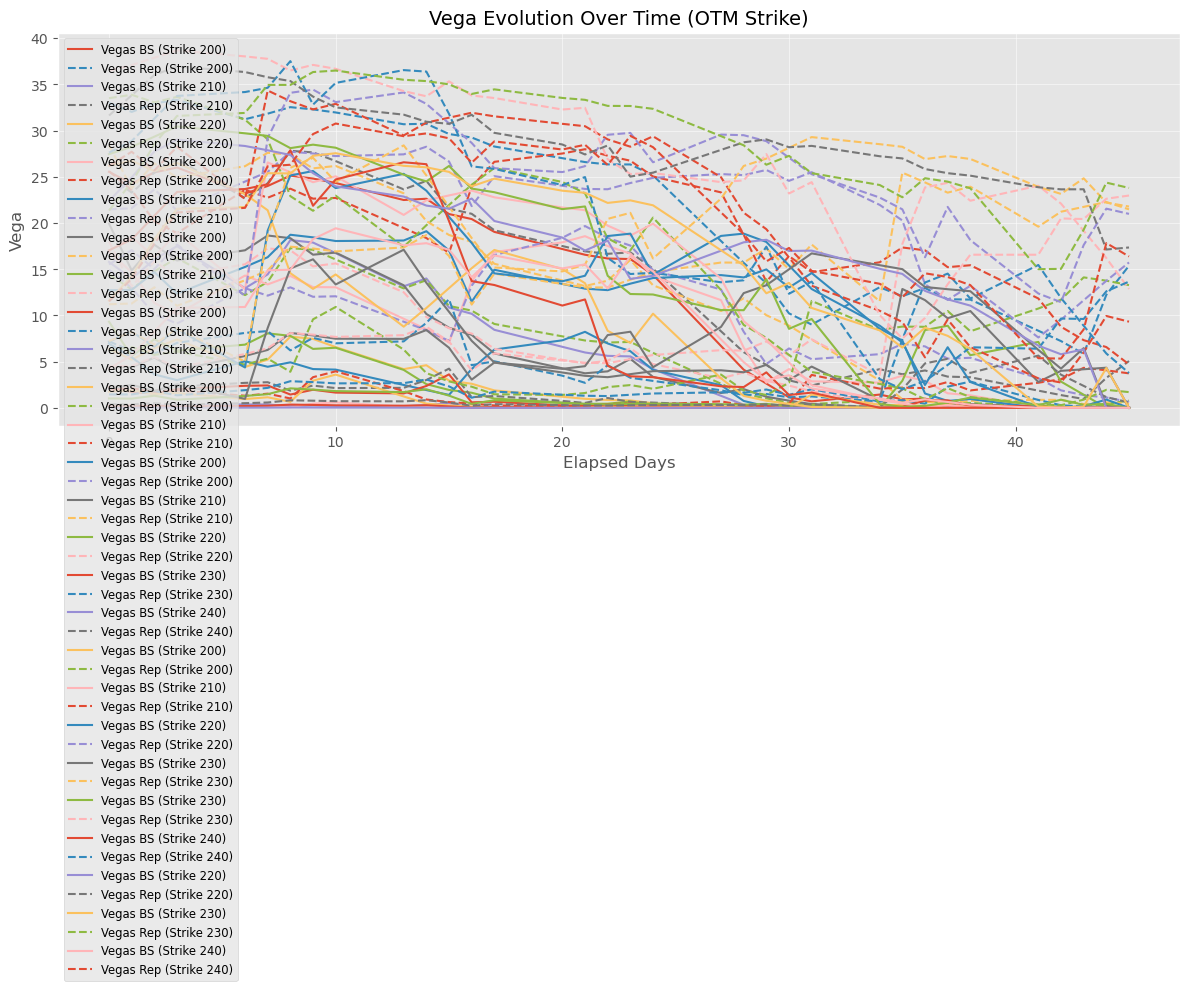

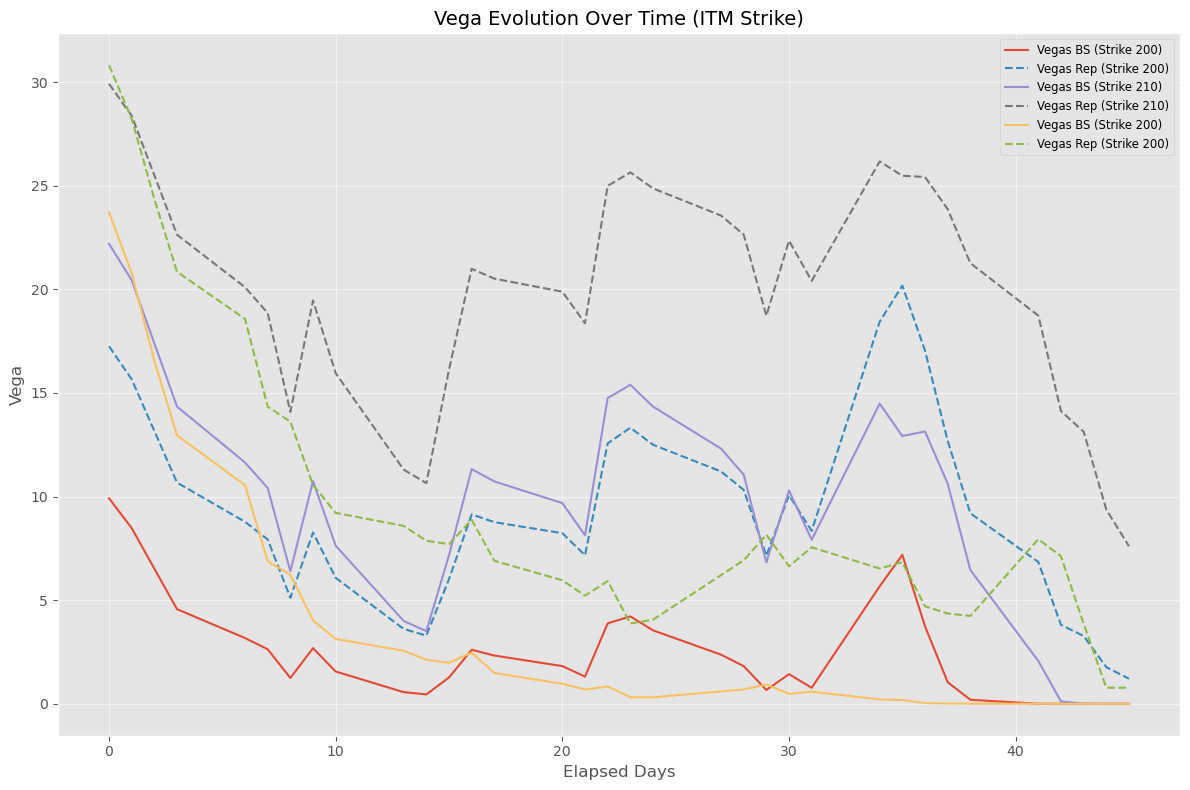

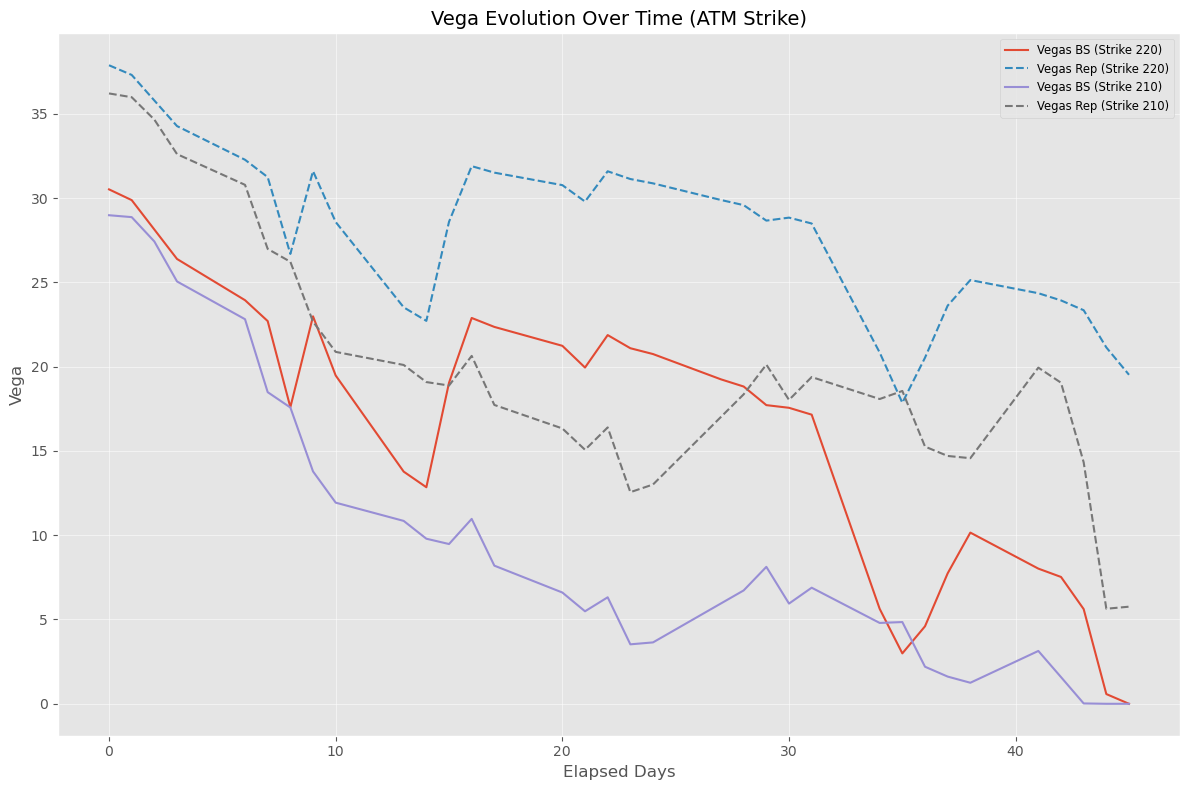

In [129]:
categories = results_df['Strike_Category'].unique()

for category in categories:
    strike_to_plot = results_df[results_df['Strike_Category'] == category]
    
    plt.figure(figsize=(12, 8))
    for idx, row in strike_to_plot.iterrows():
        option_period = eval(row['Option_Period']) if isinstance(row['Option_Period'], str) else row['Option_Period']
        vegas_bs = eval(row['Vegas_BS']) if isinstance(row['Vegas_BS'], str) else row['Vegas_BS']
        vegas_rep = eval(row['Vegas_Rep']) if isinstance(row['Vegas_Rep'], str) else row['Vegas_Rep']
        
        plt.plot(option_period, vegas_bs, label=f"Vegas BS (Strike {row['Strike']})", linestyle='-')
        plt.plot(option_period, vegas_rep, label=f"Vegas Rep (Strike {row['Strike']})", linestyle='--')

    plt.title(f'Vega Evolution Over Time ({category} Strike)', fontsize=14)
    plt.xlabel('Elapsed Days', fontsize=12)
    plt.ylabel('Vega', fontsize=12)
    plt.legend(fontsize='small', loc='best')
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()